In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import os
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import pathlib
import shutil
import tempfile
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers

# Data

The data set which will be used in this notebook is from kaggle. You can visit the following link for it: https://www.kaggle.com/c/nlp-getting-started. In total, there are 10900 tweets in this data set. 

**The features consist of:**


**id**: ID of the tweet (int64).

**keyword**: The keyword of the tweet (String).

**location**: The location of the tweet (String).

**text**: The tweet (String).

**target:** The classification of the tweet as either a disaster or not indicated by a 1 or 0 respectively.


In [3]:
df = pd.read_csv("datasets/nlp-getting-started/train.csv")

Here's a quick look at the data set:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.shape

(7613, 5)

In [6]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Below is a good indication that there isn't a lot of imbalance:

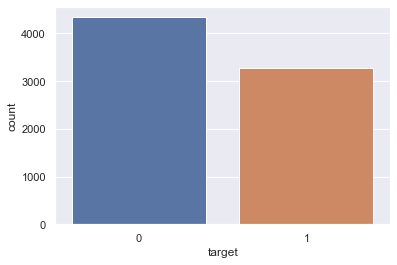

In [7]:
sns.set_theme()
new_data = pd.read_csv("datasets/nlp-getting-started/train.csv")
ax = sns.countplot(x="target", data=new_data)

In [8]:
print((df.target == 1).sum()) # Disaster
print((df.target == 0).sum()) # Not a disaster

3271
4342


Below we have two methods; one of which removes the URL because they do not add any meaning to the tweet. 
The punctuation will also be removed because they may affect the analysis of the text.

In [9]:
# Preprocessing 
import re # regular expression
import string

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

# https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate/34294022
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Here is a demonstration as to how the text will be processed:

In [10]:
pattern = re.compile(r"https?://(\S+|www)\.\S+")
for t in df.text:
    matches = pattern.findall(t)
    for match in matches:
        print(t)
        print(match)
        print(pattern.sub(r"", t))
    if len(matches) > 0:
        break

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
t
@bbcmtd Wholesale Markets ablaze 


In [11]:
df["text"] = df.text.map(remove_URL) # map(lambda x: remove_URL(x))
df["text"] = df.text.map(remove_punct)

Next up, we will be utilizing the natural language tool kit and removing stop words.

Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

# https://stackoverflow.com/questions/5486337/how-to-remove-stop-words-using-nltk-or-python
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayaznakhuda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [14]:
df["text"] = df.text.map(remove_stopwords)

In [15]:
df.text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                      m194 0104 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

We need to be able to take this text and transform this into a representation that our model understands. Below is a method which goes through each line of text, and gets the occurance of words in the data set. 

In [16]:
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df.text)

In [17]:
len(counter)

17971

In [18]:
counter

Counter({'deeds': 2,
         'reason': 20,
         'earthquake': 50,
         'may': 88,
         'allah': 9,
         'forgive': 2,
         'us': 164,
         'forest': 65,
         'fire': 250,
         'near': 54,
         'la': 25,
         'ronge': 1,
         'sask': 1,
         'canada': 11,
         'residents': 8,
         'asked': 9,
         'shelter': 6,
         'place': 26,
         'notified': 1,
         'officers': 8,
         'evacuation': 50,
         'orders': 11,
         'expected': 15,
         '13000': 4,
         'people': 196,
         'receive': 2,
         'wildfires': 11,
         'california': 117,
         'got': 112,
         'sent': 13,
         'photo': 41,
         'ruby': 1,
         'alaska': 6,
         'smoke': 48,
         'pours': 1,
         'school': 66,
         'rockyfire': 4,
         'update': 37,
         'hwy': 9,
         '20': 26,
         'closed': 20,
         'directions': 1,
         'due': 31,
         'lake': 14,
         'co

In [19]:
counter.most_common(5)

[('like', 345), ('im', 299), ('amp', 298), ('fire', 250), ('get', 229)]

In [20]:
num_unique_words = len(counter)

In [21]:
# Split dataset into training and validation set
train_size = int(df.shape[0] * 0.8)

train_df = df[:train_size]
val_df = df[train_size:(train_size+1000)]
test_df = df[(train_size+1000):]

# split text and labels
train_sentences = train_df.text.to_numpy()
train_labels = train_df.target.to_numpy()
val_sentences = val_df.text.to_numpy()
val_labels = val_df.target.to_numpy()
test_sentences = test_df.text.to_numpy()
test_labels = test_df.target.to_numpy()

In [22]:
val_labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
train_sentences.shape, val_sentences.shape, test_sentences.shape

((6090,), (1000,), (523,))

Tokenization will be done here. Each text will be turned into a sequence of integers. 

In [24]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [25]:
# each word has unique index
word_index = tokenizer.word_index

In [26]:
word_index

{'like': 1,
 'amp': 2,
 'fire': 3,
 'im': 4,
 'get': 5,
 'via': 6,
 'new': 7,
 'people': 8,
 'news': 9,
 'dont': 10,
 'emergency': 11,
 'one': 12,
 '2': 13,
 'us': 14,
 'video': 15,
 'disaster': 16,
 'burning': 17,
 'body': 18,
 'would': 19,
 'buildings': 20,
 'police': 21,
 'crash': 22,
 'first': 23,
 'california': 24,
 'still': 25,
 'man': 26,
 'got': 27,
 'know': 28,
 'day': 29,
 'back': 30,
 'going': 31,
 'two': 32,
 'time': 33,
 'full': 34,
 'accident': 35,
 'see': 36,
 'world': 37,
 'attack': 38,
 'nuclear': 39,
 'youtube': 40,
 'may': 41,
 'love': 42,
 'go': 43,
 'rt': 44,
 'many': 45,
 'cant': 46,
 '3': 47,
 'watch': 48,
 'collapse': 49,
 'dead': 50,
 'today': 51,
 'car': 52,
 'mass': 53,
 'want': 54,
 'years': 55,
 'work': 56,
 'train': 57,
 'last': 58,
 'good': 59,
 'think': 60,
 'families': 61,
 'hiroshima': 62,
 'life': 63,
 'fires': 64,
 'best': 65,
 'could': 66,
 'say': 67,
 'u': 68,
 'death': 69,
 'hot': 70,
 'forest': 71,
 'way': 72,
 'killed': 73,
 'need': 74,
 'legion

In [27]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [28]:
print(train_sentences[10:15])
print(train_sequences[10:15])

['three people died heat wave far'
 'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding'
 'raining flooding florida tampabay tampa 18 19 days ive lost count'
 'flood bago myanmar arrived bago'
 'damage school bus 80 multi car crash breaking']
[[520, 8, 395, 156, 297, 411], [749, 470, 2248, 138, 2249, 2813, 521, 611, 188, 470, 2248, 189, 189, 5679, 117], [2814, 117, 1884, 5680, 2248, 1285, 1450, 522, 256, 644, 2815], [99, 3742, 612, 1451, 3742], [111, 91, 336, 3743, 3744, 52, 22, 312]]


Now we must deal with the problem of each element in the sequences being of different length. So, we must use padding to fix this.

In [29]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape, test_padded.shape

((6090, 20), (1000, 20), (523, 20))

In [30]:
train_padded[10]

array([520,   8, 395, 156, 297, 411,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [31]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

three people died heat wave far
[520, 8, 395, 156, 297, 411]
[520   8 395 156 297 411   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


Next, we reverse the dictionary where the key is the index and the value is the word.

In [32]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [33]:
reverse_word_index

{1: 'like',
 2: 'amp',
 3: 'fire',
 4: 'im',
 5: 'get',
 6: 'via',
 7: 'new',
 8: 'people',
 9: 'news',
 10: 'dont',
 11: 'emergency',
 12: 'one',
 13: '2',
 14: 'us',
 15: 'video',
 16: 'disaster',
 17: 'burning',
 18: 'body',
 19: 'would',
 20: 'buildings',
 21: 'police',
 22: 'crash',
 23: 'first',
 24: 'california',
 25: 'still',
 26: 'man',
 27: 'got',
 28: 'know',
 29: 'day',
 30: 'back',
 31: 'going',
 32: 'two',
 33: 'time',
 34: 'full',
 35: 'accident',
 36: 'see',
 37: 'world',
 38: 'attack',
 39: 'nuclear',
 40: 'youtube',
 41: 'may',
 42: 'love',
 43: 'go',
 44: 'rt',
 45: 'many',
 46: 'cant',
 47: '3',
 48: 'watch',
 49: 'collapse',
 50: 'dead',
 51: 'today',
 52: 'car',
 53: 'mass',
 54: 'want',
 55: 'years',
 56: 'work',
 57: 'train',
 58: 'last',
 59: 'good',
 60: 'think',
 61: 'families',
 62: 'hiroshima',
 63: 'life',
 64: 'fires',
 65: 'best',
 66: 'could',
 67: 'say',
 68: 'u',
 69: 'death',
 70: 'hot',
 71: 'forest',
 72: 'way',
 73: 'killed',
 74: 'need',
 75: 'le

In [34]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [35]:
decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[520, 8, 395, 156, 297, 411]
three people died heat wave far


Thus, our decoding is correct.

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture. LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series.

In [36]:
# Create LSTM model
from tensorflow.keras import layers

# Embedding: https://www.tensorflow.org/tutorials/text/word_embeddings
# Turns positive integers (indexes) into dense vectors of fixed size. (other approach could be one-hot-encoding)

# Word embeddings give us a way to use an efficient, dense representation in which similar words have 
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify).

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.


model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            575072    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 599,969
Trainable params: 599,969
Non-trainable params: 0
_________________________________________________________________


In [37]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [65]:
history = model.fit(train_padded, train_labels, epochs=200, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/200
191/191 - 1s - loss: 0.0396 - accuracy: 0.9819 - val_loss: 1.5863 - val_accuracy: 0.6990
Epoch 2/200
191/191 - 1s - loss: 0.0378 - accuracy: 0.9824 - val_loss: 1.5857 - val_accuracy: 0.6870
Epoch 3/200
191/191 - 1s - loss: 0.0298 - accuracy: 0.9864 - val_loss: 1.6174 - val_accuracy: 0.6990
Epoch 4/200
191/191 - 1s - loss: 0.0269 - accuracy: 0.9859 - val_loss: 2.1485 - val_accuracy: 0.7000
Epoch 5/200
191/191 - 1s - loss: 0.0279 - accuracy: 0.9856 - val_loss: 2.1018 - val_accuracy: 0.7100
Epoch 6/200
191/191 - 1s - loss: 0.0302 - accuracy: 0.9857 - val_loss: 2.0132 - val_accuracy: 0.7080
Epoch 7/200
191/191 - 1s - loss: 0.0265 - accuracy: 0.9860 - val_loss: 2.2814 - val_accuracy: 0.7040
Epoch 8/200
191/191 - 1s - loss: 0.0281 - accuracy: 0.9860 - val_loss: 1.6994 - val_accuracy: 0.7080
Epoch 9/200
191/191 - 2s - loss: 0.0258 - accuracy: 0.9864 - val_loss: 2.2130 - val_accuracy: 0.7000
Epoch 10/200
191/191 - 2s - loss: 0.0255 - accuracy: 0.9865 - val_loss: 2.2197 - val_accura

Epoch 82/200
191/191 - 1s - loss: 0.0259 - accuracy: 0.9869 - val_loss: 1.9965 - val_accuracy: 0.7120
Epoch 83/200
191/191 - 1s - loss: 0.0238 - accuracy: 0.9867 - val_loss: 2.2378 - val_accuracy: 0.7110
Epoch 84/200
191/191 - 1s - loss: 0.0233 - accuracy: 0.9869 - val_loss: 2.4082 - val_accuracy: 0.7120
Epoch 85/200
191/191 - 1s - loss: 0.0235 - accuracy: 0.9867 - val_loss: 2.3329 - val_accuracy: 0.7130
Epoch 86/200
191/191 - 1s - loss: 0.0234 - accuracy: 0.9872 - val_loss: 2.5575 - val_accuracy: 0.7080
Epoch 87/200
191/191 - 1s - loss: 0.0234 - accuracy: 0.9875 - val_loss: 2.6322 - val_accuracy: 0.7080
Epoch 88/200
191/191 - 1s - loss: 0.0248 - accuracy: 0.9867 - val_loss: 2.3927 - val_accuracy: 0.7100
Epoch 89/200
191/191 - 1s - loss: 0.0233 - accuracy: 0.9872 - val_loss: 2.5015 - val_accuracy: 0.7100
Epoch 90/200
191/191 - 1s - loss: 0.0234 - accuracy: 0.9870 - val_loss: 2.6445 - val_accuracy: 0.7140
Epoch 91/200
191/191 - 1s - loss: 0.0233 - accuracy: 0.9867 - val_loss: 2.7756 - v

Epoch 162/200
191/191 - 1s - loss: 0.0230 - accuracy: 0.9870 - val_loss: 2.8757 - val_accuracy: 0.7050
Epoch 163/200
191/191 - 1s - loss: 0.0230 - accuracy: 0.9867 - val_loss: 2.9188 - val_accuracy: 0.7070
Epoch 164/200
191/191 - 1s - loss: 0.0229 - accuracy: 0.9872 - val_loss: 2.8524 - val_accuracy: 0.7050
Epoch 165/200
191/191 - 2s - loss: 0.0230 - accuracy: 0.9872 - val_loss: 2.9111 - val_accuracy: 0.7040
Epoch 166/200
191/191 - 1s - loss: 0.0229 - accuracy: 0.9877 - val_loss: 2.9992 - val_accuracy: 0.7040
Epoch 167/200
191/191 - 2s - loss: 0.0243 - accuracy: 0.9859 - val_loss: 2.7982 - val_accuracy: 0.7030
Epoch 168/200
191/191 - 1s - loss: 0.0232 - accuracy: 0.9874 - val_loss: 2.8527 - val_accuracy: 0.7000
Epoch 169/200
191/191 - 2s - loss: 0.0235 - accuracy: 0.9877 - val_loss: 2.7634 - val_accuracy: 0.6980
Epoch 170/200
191/191 - 1s - loss: 0.0244 - accuracy: 0.9875 - val_loss: 2.3441 - val_accuracy: 0.6880
Epoch 171/200
191/191 - 1s - loss: 0.0292 - accuracy: 0.9859 - val_loss: 

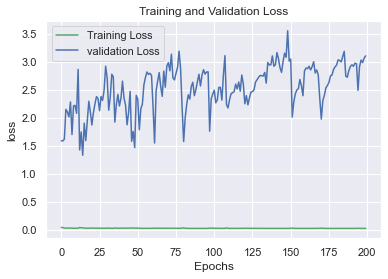

In [67]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,200)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [40]:
#model.save("LSTM_Disaster_Class_1")

INFO:tensorflow:Assets written to: LSTM_Disaster_Class_1/assets


INFO:tensorflow:Assets written to: LSTM_Disaster_Class_1/assets


The lower validation accuracy might be a sign of overfitting. Roughly speaking, the train loss seems to be decreasing while the validation loss increases. Overfitting can happen when the model memorizes the data in the training set and does not generalize to the test data set.

In [41]:
predictions = model.predict(train_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

In [42]:
print(train_sentences[10:20])

print(train_labels[10:20])
print(predictions[10:20])

['three people died heat wave far'
 'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding'
 'raining flooding florida tampabay tampa 18 19 days ive lost count'
 'flood bago myanmar arrived bago'
 'damage school bus 80 multi car crash breaking' 'whats man' 'love fruits'
 'summer lovely' 'car fast' 'goooooooaaaaaal']
[1 1 1 1 1 0 0 0 0 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes. https://keras.io/api/layers/regularizers/.

The cost can come in two flavours:
    
- L1 regularization, where the cost added is proportional to the absolute value 
  of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
    
    
- L2 regularization (the more popular choice), where the cost added is proportional to the   square of the value of the weights coefficients (i.e. to what is called the 
  squared "L2 norm" of the weights). L2 regularization is also called weight decay 
  in the context of neural networks. Don't let the different name confuse you: 
  weight decay is mathematically the exact same as L2 regularization.
  
  For more information see: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

In [43]:
FEATURES = 20

In [44]:
def compile_and_fit(model, name, optimizer=None, max_epochs= 200):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(train_padded,train_labels, steps_per_epoch = STEPS_PER_EPOCH, epochs=max_epochs, validation_data= (val_padded, val_labels),
    callbacks=get_callbacks(name),
    verbose=2)

  return history

In [45]:
STEPS_PER_EPOCH = int( np.ceil(train_padded.shape[0] / 32) ) ##32 is the batch size

In [46]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)


def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [47]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [57]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [58]:
l2_model = keras.models.Sequential()
l2_model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.


l2_model.add(layers.LSTM(64, activity_regularizer=regularizers.l2(0.0001), dropout=0.3))
l2_model.add(layers.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.0001)))

#l2_model.summary()



history2 = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 32)            575072    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 599,969
Trainable params: 599,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


191/191 - 4s - loss: 0.5624 - binary_crossentropy: 0.5629 - accuracy: 0.7039 - val_loss: 0.5060 - val_binary_crossentropy: 0.5030 - val_accuracy: 0.7610

Epoch: 0, accuracy:0.7039,  binary_crossentropy:0.5629,  loss:0.5624,  val_accuracy:0.7610,  val_binary_crossentropy:0.5030,  val_loss:0.5060,  
.Epoch 2/200
191/191 - 1s - loss: 0.3167 - binary_crossentropy: 0.3168 - accuracy: 0.8780 - val_loss: 0.4853 - val_binary_crossentropy: 0.4783 - val_accuracy: 0.7850
.Epoch 3/200
191/191 - 1s - loss: 0.1833 - binary_crossentropy: 0.1823 - accuracy: 0.9353 - val_loss: 0.5642 - val_binary_crossentropy: 0.5534 - val_accuracy: 0.7450
.Epoch 4/200
191/191 - 1s - loss: 0.1243 - binary_crossentropy: 0.1227 - accuracy: 0.9603 - val_loss: 0.7791 - val_binary_crossentropy: 0.7616 - val_accuracy: 0.7560
.Epoch 5/200
191/191 - 1s - loss: 0.0955 - binary_crossentropy: 0.0950 - accuracy: 0.9708 - val_loss: 0.7423 - val_binary_crossentropy: 0.7287 - val_accuracy: 0.7300
.Epoch 6/200
191/191 - 1s - loss: 0.0

.Epoch 50/200
191/191 - 1s - loss: 0.0294 - binary_crossentropy: 0.0285 - accuracy: 0.9862 - val_loss: 1.7995 - val_binary_crossentropy: 1.7567 - val_accuracy: 0.7300
.Epoch 51/200
191/191 - 1s - loss: 0.0310 - binary_crossentropy: 0.0302 - accuracy: 0.9851 - val_loss: 1.3509 - val_binary_crossentropy: 1.3213 - val_accuracy: 0.7310
.Epoch 52/200
191/191 - 1s - loss: 0.0312 - binary_crossentropy: 0.0306 - accuracy: 0.9864 - val_loss: 1.6513 - val_binary_crossentropy: 1.6166 - val_accuracy: 0.7430
.Epoch 53/200
191/191 - 1s - loss: 0.0276 - binary_crossentropy: 0.0268 - accuracy: 0.9865 - val_loss: 1.7281 - val_binary_crossentropy: 1.6946 - val_accuracy: 0.7310
.Epoch 54/200
191/191 - 1s - loss: 0.0280 - binary_crossentropy: 0.0272 - accuracy: 0.9869 - val_loss: 1.7079 - val_binary_crossentropy: 1.6686 - val_accuracy: 0.7390
.Epoch 55/200
191/191 - 1s - loss: 0.0263 - binary_crossentropy: 0.0255 - accuracy: 0.9862 - val_loss: 1.9145 - val_binary_crossentropy: 1.8782 - val_accuracy: 0.739

191/191 - 1s - loss: 0.0259 - binary_crossentropy: 0.0254 - accuracy: 0.9872 - val_loss: 2.2051 - val_binary_crossentropy: 2.1944 - val_accuracy: 0.7050
.Epoch 100/200
191/191 - 1s - loss: 0.0257 - binary_crossentropy: 0.0252 - accuracy: 0.9864 - val_loss: 2.2217 - val_binary_crossentropy: 2.2144 - val_accuracy: 0.7010
.Epoch 101/200
191/191 - 1s - loss: 0.0241 - binary_crossentropy: 0.0235 - accuracy: 0.9862 - val_loss: 2.2440 - val_binary_crossentropy: 2.2365 - val_accuracy: 0.7020

Epoch: 100, accuracy:0.9862,  binary_crossentropy:0.0235,  loss:0.0241,  val_accuracy:0.7020,  val_binary_crossentropy:2.2365,  val_loss:2.2440,  
.Epoch 102/200
191/191 - 1s - loss: 0.0262 - binary_crossentropy: 0.0257 - accuracy: 0.9872 - val_loss: 1.9959 - val_binary_crossentropy: 1.9875 - val_accuracy: 0.7070
.Epoch 103/200
191/191 - 1s - loss: 0.0257 - binary_crossentropy: 0.0254 - accuracy: 0.9856 - val_loss: 1.9105 - val_binary_crossentropy: 1.9047 - val_accuracy: 0.7130
.Epoch 104/200
191/191 - 1s

.Epoch 147/200
191/191 - 1s - loss: 0.0242 - binary_crossentropy: 0.0242 - accuracy: 0.9870 - val_loss: 2.2410 - val_binary_crossentropy: 2.2079 - val_accuracy: 0.7110
.Epoch 148/200
191/191 - 1s - loss: 0.0237 - binary_crossentropy: 0.0235 - accuracy: 0.9862 - val_loss: 2.3692 - val_binary_crossentropy: 2.3374 - val_accuracy: 0.7100
.Epoch 149/200
191/191 - 1s - loss: 0.0267 - binary_crossentropy: 0.0264 - accuracy: 0.9867 - val_loss: 2.1244 - val_binary_crossentropy: 2.1079 - val_accuracy: 0.7090
.Epoch 150/200
191/191 - 1s - loss: 0.0236 - binary_crossentropy: 0.0233 - accuracy: 0.9875 - val_loss: 2.3188 - val_binary_crossentropy: 2.3067 - val_accuracy: 0.7130
.Epoch 151/200
191/191 - 1s - loss: 0.0250 - binary_crossentropy: 0.0246 - accuracy: 0.9864 - val_loss: 2.2479 - val_binary_crossentropy: 2.2321 - val_accuracy: 0.7090
.Epoch 152/200
191/191 - 1s - loss: 0.0248 - binary_crossentropy: 0.0244 - accuracy: 0.9860 - val_loss: 2.1583 - val_binary_crossentropy: 2.1449 - val_accuracy:

.Epoch 196/200
191/191 - 1s - loss: 0.0237 - binary_crossentropy: 0.0234 - accuracy: 0.9872 - val_loss: 2.2611 - val_binary_crossentropy: 2.2499 - val_accuracy: 0.7140
.Epoch 197/200
191/191 - 1s - loss: 0.0232 - binary_crossentropy: 0.0228 - accuracy: 0.9874 - val_loss: 2.4491 - val_binary_crossentropy: 2.4468 - val_accuracy: 0.7050
.Epoch 198/200
191/191 - 1s - loss: 0.0232 - binary_crossentropy: 0.0228 - accuracy: 0.9877 - val_loss: 2.4123 - val_binary_crossentropy: 2.4072 - val_accuracy: 0.7080
.Epoch 199/200
191/191 - 1s - loss: 0.0232 - binary_crossentropy: 0.0228 - accuracy: 0.9867 - val_loss: 2.4633 - val_binary_crossentropy: 2.4622 - val_accuracy: 0.7080
.Epoch 200/200
191/191 - 1s - loss: 0.0234 - binary_crossentropy: 0.0231 - accuracy: 0.9869 - val_loss: 2.1177 - val_binary_crossentropy: 2.0900 - val_accuracy: 0.7180
.

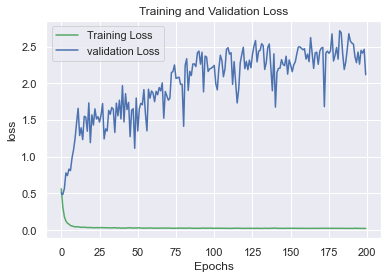

In [64]:
loss_train = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(0,200)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Conclusion

In this notebook, my goal was to gain knowledge and experience in natural language processing and neural networks. I used a dataset which consisted of tweets that needed to be classified as a disaster or not. I decided to use a LSTM neural network because it is typically used in analyzing text. The initial results were decent, but I wanted to improve the validation score and limit over-fitting. To do this, I used L2 regularization and drop out. Still, there was overfitting and overall, the results after making the changes were minimal. After doing some reseach in an attempt to get better results, I came across transformers and in particular BERT (Bidirectional Encoder Representations from Transformers). So, I implemented BERT in the other file which is included in this folder on my Github.
